# Assessments 3 - ISY503 Intelligent Systems
# Sentiment Analysis of Amazon Product Reviews

# 1. Initial Configuration
In the initial configuration, Google Drive was mounted using drive.mount('/content/drive') to connect Colab’s temporary runtime with persistent cloud storage. This step is necessary because files stored directly in Colab are deleted once the session ends, while Drive provides a permanent location for datasets, scripts, model checkpoints, and outputs. Mounting enables seamless access to files under /content/drive/MyDrive/, allowing datasets to be loaded, results to be saved, and project resources to be organized in a consistent location. This configuration ensures persistence, reproducibility, and efficient handling of large datasets without repeated uploads.

In [36]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using device: cuda:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The system path was updated by appending the project directory located in Google Drive (/content/drive/MyDrive/ISY503) to sys.path. This was done to ensure that Python recognizes the folder as a valid source for modules and packages, allowing scripts and custom code stored in that directory to be imported directly into the Colab environment. Without this step, Python would not automatically search the Google Drive project folder when resolving imports, making it necessary to adjust the path manually for seamless integration and modular code reuse.

In [37]:
import sys

# Define the project directory in Google Drive
SKELETON_DIR  = '/content/drive/MyDrive/ISY503'

# Add the project directory to Python's module search path.
# This allows direct importing of custom modules and scripts
# located in the DLE602 folder without changing the working directory.
if SKELETON_DIR not in sys.path:
    sys.path.append(SKELETON_DIR)

In [38]:
# This snippet ensures compatibility with deprecated 'imp.reload' by
# mapping it to 'importlib.reload'. It then enables IPython's autoreload
# extension, which automatically reloads imported modules before executing
# code. This is useful during development so that changes in external
# modules are picked up without restarting the interpreter.
import importlib, types, sys
sys.modules['imp'] = types.SimpleNamespace(reload=importlib.reload)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# installing required libraries
!pip3 install -q -r {SKELETON_DIR}/requirements.txt

In [40]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from config import CFG

# set configuration path and data for project
cfg = CFG(SKELETON_DIR)

# Set benchmark to True for performance improvements in cuDNN
torch.backends.cudnn.benchmark = True

# Determine the device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the default figure size for matplotlib plots
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

# 2. Dataset: Multi-Domain Sentiment Dataset

The Multi-Domain Sentiment Dataset is a widely used benchmark for sentiment classification, particularly in the context of domain adaptation research. It consists of Amazon product reviews collected across four distinct domains: Books, DVDs, Electronics, and Kitchen appliances. Each review is associated with a star rating (1–5 stars), which enables experimentation with both binary sentiment classification (positive vs. negative) and multi-class sentiment analysis.

The dataset is organized by domain, and within each domain, reviews are further separated into positive, negative, and unlabeled sets. Reviews are formatted in a pseudo-XML structure, containing metadata such as reviewer, product information, and review text. While this metadata can be useful, researchers are advised to handle duplicate review identifiers carefully, as not all IDs are unique.

The version selected for this work is the 30 MB release, which provides a compact yet comprehensive dataset suitable for efficient experimentation. It can be accessed via the following link:
https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz

For this project the dataset will be used for binary classification task such as positive or negative sentiment analysis.

In [41]:
from src import dataset

root_dir = dataset.download_and_extract_dataset(cfg)
print(root_dir)

Dataset archive already exists, skipping download.
Extracting dataset...
Dataset extracted to: dataset
dataset/sorted_data_acl


In [42]:
df = dataset.load_multi_domain_dataframe(root_dir, include_unlabeled=False)
df.head(10)

,text,label,domain
0,<review> <unique_id> 0785758968:one_of_the_bes...,1,books
1,The story revolves around a man named Norman J...,1,books
2,This novel does not have the research that som...,1,books
3,I would strongly recommend this book </review_...,1,books
4,</helpful> <rating> 5.0 </rating> <title> Beau...,1,books
5,This book packs the punch of great fiction. It...,1,books
6,Jared Diamond places a very strong emphasis on...,1,books
7,If you don't know a lot about history or how p...,1,books
8,"In short, this book magnificently illuminates ...",1,books
9,</helpful> <rating> 5.0 </rating> <title> Beau...,1,books


In [43]:
df['label'].value_counts()

,count
label,
1,5705
0,5098


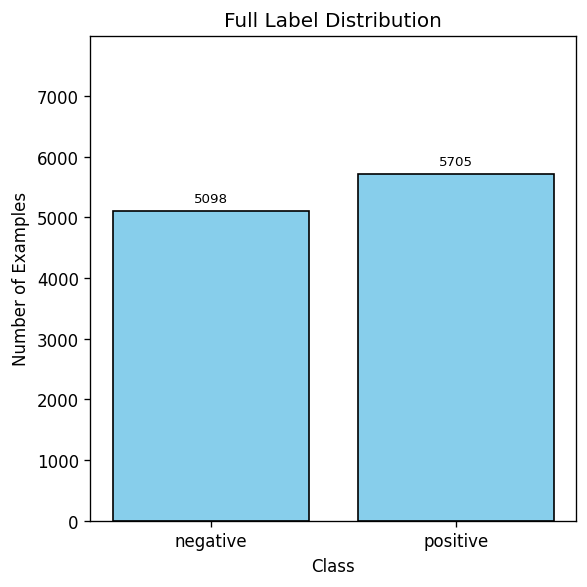

In [44]:
from src import explore

df_labels = df['label']
explore.plot_label_distribution(df_labels, "Full")

The dataset exhibits a relatively balanced distribution of sentiment classes, with 5,705 positive reviews and 5,098 negative reviews. This slight class imbalance favors positive reviews, but the difference is small enough that it should not pose a significant challenge for most classification models. Such balance is advantageous, as it reduces the likelihood of biased predictions and supports robust training and evaluation of sentiment analysis models.

# 3. Data Preparation

In [45]:
import utils

train_df, test_df = utils.split_dataset(df, test_size=0.2)

utils.print_shape(train_df, "Training")
utils.print_shape(test_df, "Testing")

Training Dataset has 8642 rows and 3 columns
Testing Dataset has 2161 rows and 3 columns


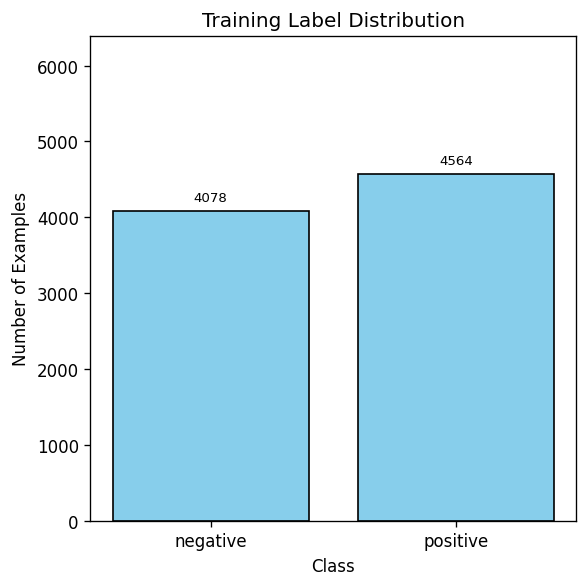

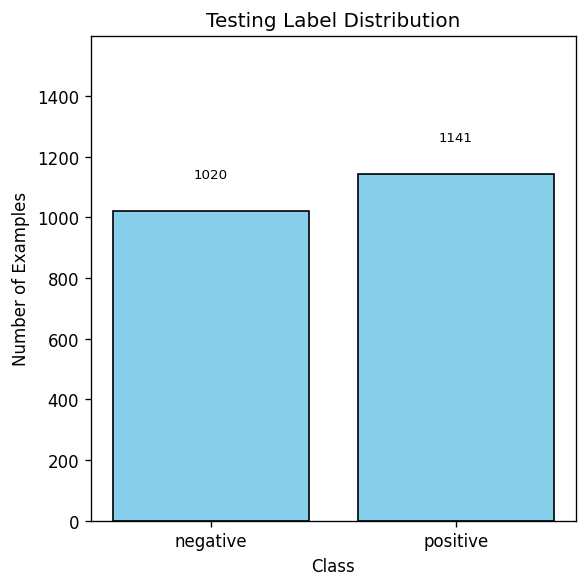

In [46]:
explore.plot_label_distribution(train_df['label'], "Training")
explore.plot_label_distribution(test_df['label'], "Testing")

The dataset has been divided into training and testing subsets with a relatively balanced label distribution using 'stratify' on label across both sets. In the training set, there are 4,564 positive examples and 4,078 negative examples, while the testing set contains 1,141 positive examples and 1,020 negative examples. Although there are slightly more positive reviews in both splits, the difference is modest, ensuring that models trained on this data will not be heavily biased toward a single class. This balance between positive and negative labels in both training and testing partitions makes the dataset well-suited for building and evaluating robust sentiment classification models.

# 3.1 Remove HTML Tags

In [47]:
from src import preprocess

preprocess.check_html_count(train_df, "text", "Training")

[Training] Total rows: 8642
[Training] Rows with HTML tags: 4275

Sample 5 rows with HTML tags in [Training]:
                                                                                                                                                                                                         text  \
5306  The strong point of this novel is the humor employed by Neil Gaiman.  On par with Douglas Adams, the author of Anasi Boys fills the pages with quirky, pop-culture laden humor.  The main character,...   
5007  </helpful> <rating> 4.0 </rating> <title> Magnificant </title> <date> November 4, 2006 </date> <reviewer> Angel M. Perez Martinez </reviewer> <reviewer_location> PR & Spain </reviewer_location> <r...   
8688  I had expected a "straight" tale similar to the Alienist.  Then when I discovered it was a humorous take on the police procedural I perked up.  It was only after the 100th hyperbole and cutesy 20t...   
494   Overall 4/5 for Survivor Series 2002. Worth buyi

In [48]:
train_df = preprocess.remove_html(train_df, "text", "Training", inplace=True)
preprocess.check_html_count(train_df, "text", "Training")

print("-" * 50)

utils.print_shape(train_df, "Training")
train_df.sample(5)["text"]

Removed HTML tags from [Training] data. Cleaned column: 'text'.
[Training] Total rows: 8642
[Training] Rows with HTML tags: 0

Sample 0 rows with HTML tags in [Training]:
Empty DataFrame
Columns: [text, html_tag_count]
Index: []
--------------------------------------------------
Training Dataset has 8642 rows and 3 columns


,text
4421,"5.0 One of my favorite movies... April 4, 2006..."
720,"Otherwise, it works B00005Q4OD:foodsaver_canni..."
3381,"Studio 54, and the Disco Era in general were a..."
282,141430725X:you're_advocating_illegal_acts.:dia...
1958,You should know something about a subject befo...


In [49]:
preprocess.check_html_count(test_df, "text", "Testing")

[Testing] Total rows: 2161
[Testing] Rows with HTML tags: 1046

Sample 5 rows with HTML tags in [Testing]:
                                                                                                                                                                                                          text  \
5832   </helpful> <rating> 5.0 </rating> <title> Great product! </title> <date> September 1, 2006 </date> <reviewer> Firas Alragom </reviewer> <reviewer_location> Kuwait </reviewer_location> <review_text...   
1032   But this sequel was too into clothes and the finer things, and full of too-successful, too-beautiful men and women. Not believable. </review_text> </review> <review> <unique_id> 006440966X:dragged...   
3043   It all works as advertised.  The only minor glitch I have had, is that when you first try to start a recording, it gives a "media full" message, even tho the media is empty.  Then you select recor...   
10422  </helpful> <rating> 5.0 </rating> <title> Movi

In [50]:
test_df = preprocess.remove_html(test_df, "text", "Testing", inplace=True)
preprocess.check_html_count(test_df, "text", "Testing")

print("-" * 50)

utils.print_shape(test_df, "Testing")
test_df.sample(5)["text"]

Removed HTML tags from [Testing] data. Cleaned column: 'text'.
[Testing] Total rows: 2161
[Testing] Rows with HTML tags: 0

Sample 0 rows with HTML tags in [Testing]:
Empty DataFrame
Columns: [text, html_tag_count]
Index: []
--------------------------------------------------
Testing Dataset has 2161 rows and 3 columns


,text
5203,"""Requiem For A Dream"" isn't helped any by Darr..."
2951,"5.0 Fun for kids and parents November 13, 2006..."
2061,There are a few laugh-out-loud moments that I ...
8925,19. A dream of an oasis -- this episode takes ...
5942,I did the Atkins diet and honestly have not st...


The preprocessing results show that both the training and testing datasets initially contained a substantial number of rows with embedded HTML tags. In the training set, out of 8,642 rows, 4,275 contained HTML elements, while in the testing set, 1,046 of 2,161 rows were affected. After cleaning, all HTML tags were successfully removed, leaving clean text-only data in both sets. The cleaned training dataset now has 8,642 rows, and the testing dataset has 2,161 rows, each represented in a structured format with three columns (including the processed text column). This ensures that the data is free from markup noise and ready for further natural language processing and sentiment analysis tasks.

# 3.2 Remove Urls

In [51]:
preprocess.count_urls(train_df, "label", "Training")

Number of URLs in Training data: 0
Samples texts containing URLs in Training data:
No URLs found


In [52]:
preprocess.count_urls(test_df, "label", "Testing")

Number of URLs in Testing data: 0
Samples texts containing URLs in Testing data:
No URLs found


The dataset revealed that no URLs were present in either the training or testing data. The inspection confirmed that the number of URLs detected was zero across both subsets, and no text samples contained embedded links. This indicates that URL removal is unnecessary for this dataset, ensuring the textual content remains clean and consistent for further preprocessing and model training.

# 3.3 Standardize Text: Contractions, Informal Expressions, and Acronyms

The Multi-Domain Sentiment Dataset, which consists of Amazon product reviews, contains informal writing patterns such as contractions (e.g., “won’t”, “can’t”), colloquial terms, and occasional abbreviations. These variations can introduce noise and inconsistencies, making it more difficult to achieve accurate sentiment classification (Zhao et al., 2018). To address this, a systematic text standardization process is applied to normalize expressions into their standard forms, thereby improving consistency and interpretability for modeling.

This preprocessing step involves four main components:

1. Contraction Expansion
Contractions are expanded into their full forms using the contractions Python library. For example, “don’t” becomes “do not”, and “can’t” becomes “cannot”.
Source: https://pypi.org/project/contractions/

2. Informal Term Replacement
Occasional informal or slang expressions in the reviews are mapped to formal equivalents using the flashtext library for high-performance keyword replacement. A slang dictionary from an open-source repository is used as the reference.
Dictionary source: https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
FlashText library: https://github.com/vi3k6i5/flashtext

3. Acronym Expansion
Some reviews include acronyms or shorthand notations. These are expanded into their full forms using a curated JSON-based mapping file.
Abbreviation dictionary: https://github.com/prajwalkhairnar/abbreviations_py/blob/main/abbreviations_py/textes/abbreviation_mappings.json

4. Tokenization
Text is tokenized using the TweetTokenizer from the NLTK library, which is robust in handling punctuation, emoticons, and irregular formatting common in user-generated review content.
Tokenizer documentation: https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.casual.TweetTokenizer

All these operations are encapsulated in a custom TextStandardizer class, which applies contraction expansion, slang replacement, and acronym resolution sequentially. The result is a cleaned and standardized version of the review text, ready for downstream sentiment analysis tasks.

**Reference** <br>
Zhao, J., Gui, X., & Zhang, X. (2018). Deep convolution neural networks for Twitter sentiment analysis. IEEE Access, 6, 23253–23260. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8244338

In [53]:
from src.standarization import TextStandardizer

standardizer = TextStandardizer()
train_df['text'] = train_df['text'].apply(standardizer.standardize_text)
test_df['text'] = test_df['text'].apply(standardizer.standardize_text)
train_df.head()

,text,label,domain
177,Two supreme court justices are murdered by som...,1,books
7536,"Was not expecting much , but this movie was su...",1,dvd
6290,Snow WHite and the 3 stooges Greetings The fro...,0,dvd
8818,And just to add some trivia :,1,dvd
5306,The strong point of this novel is the humor em...,1,books


# 3.4 Remove Punctuations

In [54]:
preprocess.punctuation_count(train_df, "text", "training")

[training] Total rows: 8642
[training] Rows containing punctuation: 8464
[training] Total punctuation characters: 272982

Sample rows with punctuation in [training]:
                                                                                                                                                                                                         text
177   Two supreme court justices are murdered by someone who does such a good job that there are few if any clues to go on . Darby Shaw and her lover / professor are intrigued by who could have done thi...
7536  Was not expecting much , but this movie was surprisingly entertaining . Yes , it was a little violent , and some parts were a tad unbelievable , but overall , Denzel and John were worthy antagonis...
6290  Snow WHite and the 3 stooges Greetings The frozen Dead They saved Hitler's brain Black belt Jones TNT Jackson The thing with two heads Howard the Duck Billy the kid vs . Dracula Bela Legosi meets ...
8818      

,text
177,9
7536,11
6290,10
8818,1
5306,76
...,...
6877,12
3414,19
7015,19
5465,24


In [55]:
preprocess.punctuation_count(test_df, "text", "testing")

[testing] Total rows: 2161
[testing] Rows containing punctuation: 2132
[testing] Total punctuation characters: 66613

Sample rows with punctuation in [testing]:
                                                                                                                                                                                                         text
3588  Once the Nazis took power , they moved swiftly and systematically against the homosexual community . Survivors detail how they clung to vain hope--one man , for example believed that with known ho...
8780                                                                               No 8 " carving knife . But like I said above , the 8 " chef's knife works better than any carving knife that I have used .
5027  Later , Baslim calls in some favors and sends Thorby to live with the Free Traders , a group of space merchants that keep to themselves with their own unique culture . Here Thorby discovers anothe...
5832  5.0 Great

,text
3588,14
8780,6
5027,21
5832,37
6164,21
...,...
5984,2
8664,25
4095,6
4668,5


In [56]:
train_df = preprocess.remove_punctuation(train_df, "text", "training", inplace=True)
preprocess.punctuation_count(train_df, "text", "training")

Punctuation removed from [training] dataset column 'text'.
[training] Total rows: 8642
[training] Rows containing punctuation: 0
[training] Total punctuation characters: 0



,text
177,0
7536,0
6290,0
8818,0
5306,0
...,...
6877,0
3414,0
7015,0
5465,0


In [57]:
test_df = preprocess.remove_punctuation(test_df, "text", "testing", inplace=True)
preprocess.punctuation_count(train_df, "text", "testing")


Punctuation removed from [testing] dataset column 'text'.
[testing] Total rows: 8642
[testing] Rows containing punctuation: 0
[testing] Total punctuation characters: 0



,text
177,0
7536,0
6290,0
8818,0
5306,0
...,...
6877,0
3414,0
7015,0
5465,0


The punctuation analysis revealed that the majority of reviews in both the training and testing sets contained punctuation marks. In the training dataset, 8,464 out of 8,642 rows included punctuation, totaling approximately 272,982 punctuation characters. Similarly, in the testing dataset, 2,132 out of 2,161 rows contained punctuation, with about 66,613 punctuation characters. After applying the punctuation removal process, all punctuation marks were successfully eliminated from both datasets, leaving zero rows with punctuation and ensuring that the text is fully cleaned. This step helps reduce noise and standardizes the textual input, making it more suitable for downstream sentiment analysis tasks.

In [58]:
train_df['text'].head(5)

,text
177,Two supreme court justices are murdered by som...
7536,Was not expecting much but this movie was surp...
6290,Snow WHite and the 3 stooges Greetings The fro...
8818,And just to add some trivia
5306,The strong point of this novel is the humor em...


In [59]:
test_df['text'].head(5)

,text
3588,Once the Nazis took power they moved swiftly a...
8780,No 8 carving knife But like I said above the 8...
5027,Later Baslim calls in some favors and sends Th...
5832,50 Great product September 1 2006 Firas Alrago...
6164,The decisive Armada happens much too quickly l...


# 3.5 Remove Numbers

In [60]:
preprocess.count_numbers(train_df, "text", "Training")
preprocess.count_numbers(test_df, "text", "Testing")

Number of texts containing digits in Training data: 5376
Number of texts containing digits in Testing data: 1333


In [61]:
# Remove numbers from training and test data
train_df['text'] = preprocess.remove_numbers(train_df, 'text', 'Training')
test_df['text'] = preprocess.remove_numbers(test_df, 'text', 'Testing')

# Verify numbers were removed
preprocess.count_numbers(train_df, "text", "Training")
preprocess.count_numbers(test_df, "text", "Testing")

Removing digits from Training data...
Done!

Removing digits from Testing data...
Done!

Number of texts containing digits in Training data: 0
Number of texts containing digits in Testing data: 0


# 3.6 Remove Non-ASCII

In [62]:
train_idx = preprocess.count_non_ascii(train_df, "text", "Training")
test_idx = preprocess.count_non_ascii(test_df, "text", "Testing")

Tweets containing non-ASCII characters in Training data: 348
Tweets containing non-ASCII characters in Testing data: 91


In [63]:
# modify the text with non-ascii characters using index of non-ascii characters
train_df.loc[train_idx, 'text'] = train_df.loc[train_idx, 'text'].apply(preprocess.remove_non_ascii)
test_df.loc[test_idx, 'text'] = test_df.loc[test_idx, 'text'].apply(preprocess.remove_non_ascii)

preprocess.count_non_ascii(train_df, "text", "Training")
preprocess.count_non_ascii(test_df, "text", "Testing")

Tweets containing non-ASCII characters in Training data: 0
Tweets containing non-ASCII characters in Testing data: 0


[]

# 3.7 Stop Words

Stop words are common words in a language, such as “the”, “an”, and “than”, that occur very frequently but carry little meaningful information for text analysis. A standard preprocessing step is to remove these words using predefined stopword lists, which have been established in prior studies.

The NLTK library offers extensive stopword lists for different languages. By importing NLTK and downloading its stopwords corpus, these lists can be applied during preprocessing. Frequently used pronouns like “I”, “we”, and “you” are also removed, along with other stopwords, to minimize noise and enhance the quality of text analysis.

In [64]:
train_df['text'] = train_df['text'].apply(preprocess.remove_stopwords)
test_df['text'] = test_df['text'].apply(preprocess.remove_stopwords)

train_df.head()

,text,label,domain
177,two supreme court justices murdered someone go...,1,books
7536,expecting much movie surprisingly entertaining...,1,dvd
6290,snow white stooges greetings frozen dead saved...,0,dvd
8818,add trivia,1,dvd
5306,strong point novel humor employed neil gaiman ...,1,books


# 3.8 Outliers

Outlier detection and removal in the dataset was carried out based on the word length (token count) of each review. For every entry, the number of words was computed from the text column, and quantile thresholds were applied to identify extreme cases. By default, reviews falling below the 2nd percentile or above the 99th percentile of word length were flagged as outliers.

Reviews shorter than the lower cutoff (extremely short texts, often containing zero or very few words) and those longer than the upper cutoff (unusually lengthy reviews with excessive word counts) were removed. This approach ensured that the majority of reviews (inliers) were retained while eliminating noisy or unrepresentative samples.

The method provided detailed statistics, including the quantile cutoffs, the total number of rows before and after cleaning, and the count of outliers removed. Sample outliers were also displayed for inspection, showcasing examples of reviews that were either abnormally short or excessively long.

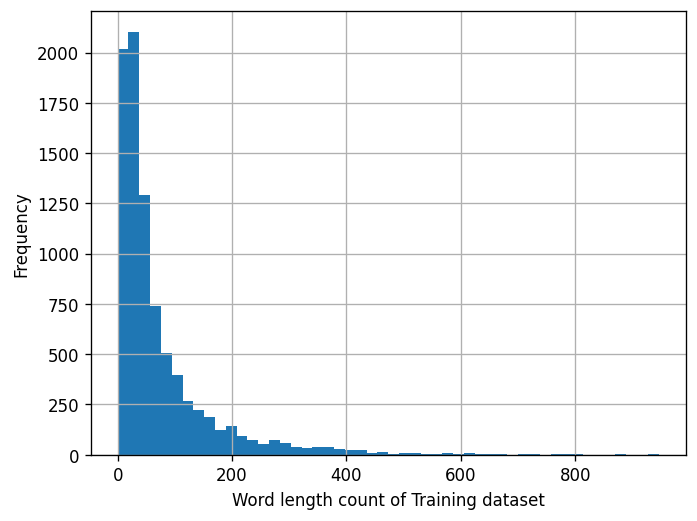

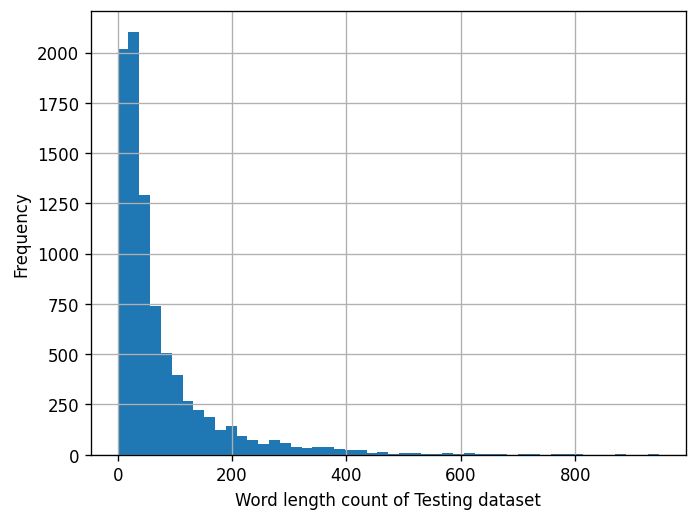

In [65]:
preprocess.show_word_count(train_df, "text", "Training")
preprocess.show_word_count(train_df, "text", "Testing")

[Training] Column: 'text'
  Quantile cutoffs: low=1.000, high=435.000
  Total rows: 8642 | Inliers kept: 8398 | Outliers removed: 244

Examples of outliers:


,text,label,domain,word_len
171,,1,books,0
5799,,1,electronics,0
1164,,1,kitchen_&_housewares,0
1247,,0,kitchen_&_housewares,0
5804,,1,kitchen_&_housewares,0
10424,wow bloodlines irene kelly novel irene kelly m...,1,books,575
293,van damn november n harmon ndharmon baltimore ...,1,dvd,447
2274,bya embarrasingtowatch gordonc tait bya stuff ...,0,dvd,446
6668,plot stronger dick jane quite dr seuss level y...,1,books,643
4396,item exactly promised gift dads new wife happy...,1,kitchen_&_housewares,458


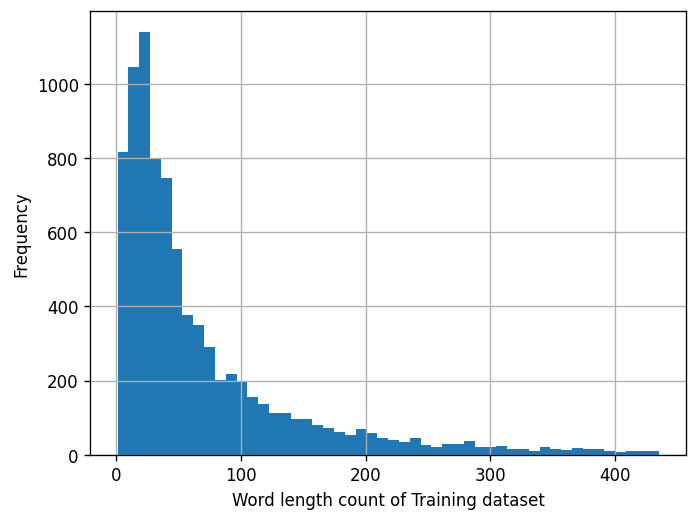

In [66]:
train_df = preprocess.remove_outliers(train_df, "text", "Training")
preprocess.show_word_count(train_df, "text", "Training")

[Testing] Column: 'text'
  Quantile cutoffs: low=2.000, high=426.400
  Total rows: 2161 | Inliers kept: 2098 | Outliers removed: 63

Examples of outliers:


,text,label,domain,word_len
3126,rating,1,dvd,1
509,,1,books,0
9880,really,0,books,1
10039,enough,1,dvd,1
7,,0,electronics,0
3523,terrible direction terrible writing almost fee...,0,dvd,567
2421,sure network wizards little beasty running tea...,0,electronics,453
7027,movie clunker november dexbet dexbet colcheste...,0,dvd,514
4499,lot people like watches superhero movies want ...,1,dvd,544
2971,reading reviews bootleg directors cut going wa...,1,dvd,592


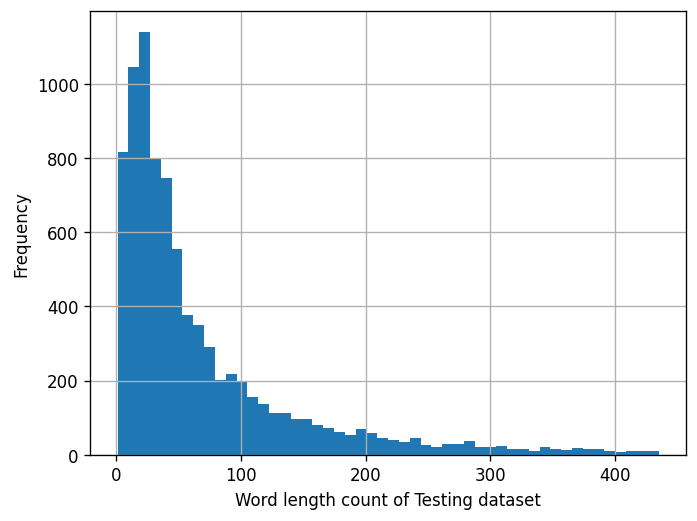

In [67]:
test_df = preprocess.remove_outliers(test_df, "text", "Testing")
preprocess.show_word_count(train_df, "text", "Testing")

The analysis of word length distributions in the training and testing datasets revealed the presence of extreme outliers. Initially, both datasets showed a long-tailed distribution, with most reviews containing fewer than 100 words but a small number extending beyond 400–600 words, and even some exceeding 800 words. Using quantile-based thresholds, these outliers were detected and removed to improve consistency.

In the training set (8,642 rows), 244 reviews were identified as outliers, leaving 8,398 valid inliers. In the testing set (2,161 rows), 63 reviews were flagged as outliers, leaving 2,098 inliers. Some of the outliers included reviews with zero word length (likely due to preprocessing artifacts) and excessively long reviews above 400 words.

After filtering, the distributions became more compact and concentrated, with the majority of reviews now falling within a practical range of 1–435 words. This step ensures that the dataset maintains realistic review lengths, reducing noise from abnormal entries and making it more suitable for training robust sentiment classification models.

# 3.9 Tokenization

To prepare the text data for model training, a custom PyTorch dataset class (TextDataset) was implemented. This class is tailored for binary sentiment classification (0 = negative, 1 = positive) and leverages the Hugging Face tokenizer to convert raw review text into standardized model inputs.

The dataset construction process begins by selecting the text column. If not explicitly specified, the class automatically identifies the column with the highest average text length (excluding the label column), ensuring the most relevant source of review content is used. Labels are extracted from the designated label column, converted to integer format, and stored as tensors of type torch.long.

The tokenizer (default: distilbert-base-uncased) processes all reviews in batch mode with the following configurations:
- Maximum sequence length is set to 128 tokens by default, with truncation applied to longer sequences and padding applied to shorter ones, producing uniform input shapes.
- Both input IDs and attention masks are generated and stored as tensors for downstream training.

The dataset class also implements the standard PyTorch methods __len__ and __getitem__. As a result, each dataset entry returns a tuple containing (input_ids, attention_mask, label), making it fully compatible with PyTorch DataLoader for efficient batch processing.


This design ensures:
- **Efficiency** – tokenization is performed once at dataset initialization, avoiding repeated preprocessing during training.
- **Consistency** – all sequences are standardized to fixed lengths, which is a strict requirement for transformer-based architectures.
- **Flexibility** – configurable parameters (e.g., sentence length, text column, model tokenizer) allow adaptation to different datasets and experimental needs.
- **Reproducibility** – encapsulating tokenization within a dataset class guarantees that both training and evaluation pipelines use the same preprocessing logic.

Through this tokenization pipeline, raw textual reviews are transformed into clean, structured, and model-ready representations, ensuring robust input preparation for fine-tuning transformer models on sentiment classification.

In [68]:
from src.dataset import TextDataset

train_ds = TextDataset(train_df, sentence_len=96, label_col="label", text_col="text")
test_ds = TextDataset(test_df, sentence_len=96, label_col="label", text_col="text")

text, masks, label = train_ds[0]
print("Tokens:", text)
print("Label:", label)

Tokens: tensor([  101,  2048,  4259,  2457, 19867,  7129,  2619,  2204,  3105, 15774,
         2175, 25844,  8233,  7089,  2934, 18896,  2071,  2589, 25844, 10228,
         2470,  7009, 21877, 19341,  2078,  4766,  6898,  2934,  2204,  2767,
         2619,  8495,  5371,  4152,  5500,  2919,  4364,  2424, 25844,  4593,
         2718, 13172,  2157,  5252,  4269,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])
Label: tensor(1)


# 4. Build Model

A DistilBERT-based classifier was implemented and fine-tuned for binary sentiment classification on the Multi-Domain Sentiment Dataset. The architecture combines a pre-trained DistilBERT encoder with a custom two-layer feedforward classification head. The design balances the power of transformer-based contextual embeddings with added regularization and flexibility to adapt to the target dataset.

Key aspects of the implementation include:
1.	**Backbone Model**
- The encoder is initialized from the Hugging Face distilbert-base-uncased checkpoint.
- Flexibility is built in to freeze the entire encoder or selectively freeze the bottom n transformer layers (out of 6). This enables control over the trade-off between leveraging pre-trained knowledge and adapting deeper layers to the dataset.
2.	**Pooling Mechanism**
- A masked mean-pooling strategy aggregates token representations, weighted by the attention mask.
- This approach captures global sequence-level information while ignoring padded tokens. As an alternative, the model supports using the first-token ([CLS]) embedding.
3.	**Classification Head**
- The pooled representation passes through a LayerNorm → Dropout → Linear → GELU → Dropout → Linear stack.
- The addition of dropout (default: 0.4) provides stronger regularization, reducing the risk of overfitting on domain-specific text.
- The head reduces the hidden dimension (768 → 384) before projecting to the target number of classes.
4.	**Optimization Strategy**
- The AdamW optimizer is used with weight decay (0.03) to improve generalization.
- Label smoothing (0.08) is applied to the cross-entropy loss to calibrate predictions, preventing the model from becoming overconfident and improving robustness.
- Training uses 16-sample mini-batches across 3 epochs, with a learning rate of 2e-5, a common fine-tuning range for transformer models.
5.	**Training Pipeline**
- The model is trained and evaluated using PyTorch DataLoaders for efficient batching.
- Reproducibility is ensured by setting a fixed random seed (torch.manual_seed(42)).
- Results are tracked with experiment identifiers (ident_str), enabling structured comparison of different training runs.


Rationale for the using this model -
- Transformer Backbone: DistilBERT provides lightweight yet powerful contextual embeddings, making it efficient for large-scale sentiment analysis while retaining strong performance.
- Layer Freezing: Partial freezing allows reuse of lower-level linguistic features while fine-tuning higher layers for domain-specific sentiment cues.
- Mean Pooling: Masked averaging captures holistic context across the review, which is advantageous compared to relying solely on a single token.
- Regularization (Dropout + Label Smoothing): These techniques mitigate overfitting and improve generalization across domains.
- Optimization Choices: AdamW with weight decay balances effective convergence with parameter regularization.

In summary, this workflow establishes a robust fine-tuned DistilBERT sentiment classifier that leverages pre-trained language representations while incorporating careful design choices such as pooling, layer freezing, and regularization—to enhance domain adaptability and prevent overfitting.

Accuracy_train,▁▇█
Accuracy_val,▁▇█
F1_train,▁▇█
F1_val,▁▇█
Loss_train,█▃▁
Loss_val,█▁▃
epoch,▁▅█
lr,█▄▁
Accuracy_train,0.80007
Accuracy_val,0.76406
F1_train,0.79912


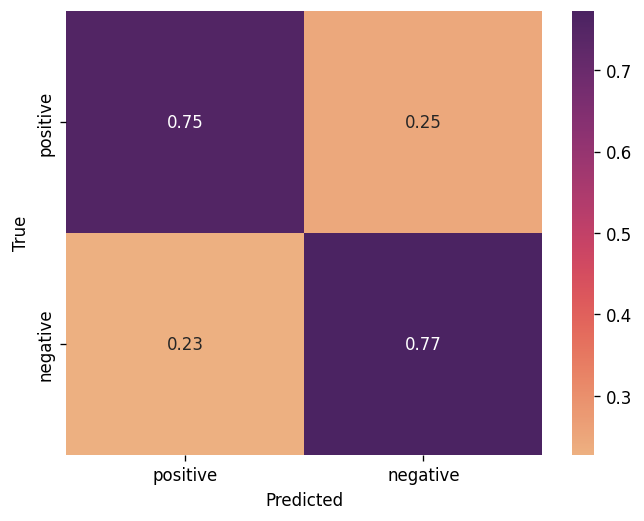

Model weights saved to: /content/drive/MyDrive/ISY503/saved_models/DistilBertForClassification_AdamW_CrossEntropyLoss_3_16_2e-05.pth


'/content/drive/MyDrive/ISY503/saved_models/DistilBertForClassification_AdamW_CrossEntropyLoss_3_16_2e-05.pth'

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from src.models import DistilBertForClassification
from src import train

torch.manual_seed(42)  # ensures reproducibility of results

NUM_EPOCHS = 3          # number of epochs for fine-tuning
BATCH_SIZE = 16         # mini-batch size
learning_rate = 2e-5    # learning rate, standard for transformer fine-tuning

# create DataLoaders for training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)   # shuffle training data for randomness
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)    # keep test data order fixed

# initialize DistilBERT classifier with custom head
# dropout=0.4 for stronger regularization, use_mean_pool=True for masked mean pooling
# freeze_n_layers=4 keeps bottom 4 layers frozen while fine-tuning higher layers
model = DistilBertForClassification(
    n_classes=cfg.num_classes,
    dropout=0.4,
    use_mean_pool=True,
    freeze_encoder=False,
    freeze_n_layers=4
)

# AdamW optimizer with weight decay (0.03) for better generalization
# only updates parameters that are not frozen
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=0.03
)

# cross-entropy loss with label smoothing (0.08) to improve calibration
# and prevent overconfident predictions
criterion = nn.CrossEntropyLoss(label_smoothing=0.08)

# experiment identifier for tracking different runs
ident_str = f"{optimizer.__class__.__name__}_{criterion.__class__.__name__}_{NUM_EPOCHS}_{BATCH_SIZE}_{learning_rate}"

# train and evaluate model using custom training loop
# project_name used for experiment grouping, ident_str for run-specific tracking
train.train_model(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    cfg.class_names,
    NUM_EPOCHS,
    project_name="ISY502_3",
    ident_str=ident_str
)

For find more detail on accuracy metrices visit :